In [2]:
## custom
from utils import utils, vis
from utils import poly_point_isect as bo   ##bentley-ottmann sweep line
import criteria as C
import quality as Q
import gd2
import utils.weight_schedule as ws

## third party
import networkx as nx

from PIL import Image
from natsort import natsorted


## sys
from collections import defaultdict
import random
import time
from glob import glob
import math
import os
from pathlib import Path
import itertools
import pickle as pkl

## numeric
import numpy as np
import scipy.io as io
import torch
from torch import nn, optim
import torch.nn.functional as F


## vis
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from IPython.display import clear_output
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


## Optimize via Stochastic Gradient Descent (SGD)

In [3]:
import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2

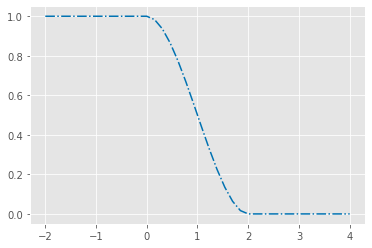

In [4]:
# s1 = ws.SmoothStepSchedule(0, 2, 0, 0.5)
# s2 = ws.SmoothStepSchedule(2, 4, 0.5, 0)
# s3 = ws.SmoothStepSchedule(5, 7, 0, 1)
# s4 = ws.SmoothStepSchedule(9,11, 1,-1)
# s = ws.Concat(s1, s2, s3, s4)
s = ws.SmoothSteps([0,2], [1,0])

t = np.linspace(-2, 4, 40)
y = [s(ti) for ti in t]
plt.plot(t,y, '-.')

In [5]:
def plot_weight(criteria_weights, max_iter, ax=None):
    
    t = np.linspace(0, max_iter,250)
    if ax is None:
        plt.figure(figsize=[12,4])
        ax = plt.subplot(111)
        
    for i,[c,w] in enumerate(criteria_weights.items()):
        if callable(w):
            y = [w(ti) for ti in t]
        else:
            y = [w for ti in t]
        ax.plot(
            t,y,
            (['-','--'])[i%2], 
            label=c,
            alpha=0.6,
            lw=3
        )

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Weight')
    ax.set_xlim(plt.xlim()[0], plt.xlim()[1]*1.2)
    ax.set_ylim(-0.1, plt.ylim()[1]*1.5)
    ax.legend()
    plt.show()

## choose a graph

In [6]:
# graph_name = '1138_bus'
# graph_name = 'd_ss'
# graph_name = 'west0132'

# graph_name = 'grid1'
# graph_name = 'grid1_dual'
# graph_name = 'odepa400'
# graph_name = 'netz4504_dual'
# graph_name = 'L'
# -----
# graph_name = 'n3c6-b1'
# graph_name = 'netz4504'
# graph_name = 'qh882'

In [10]:
graph_name = 'tree_2_6'
G = nx.balanced_tree(2,6)
max_iter = int(10e4)

# graph_name = 'grid_12_24'
# G = nx.grid_2d_graph(12,24)
# max_iter = int(1e5)

# graph_name = 'spx_teaser'
# G = utils.load_spx_teaser()
# max_iter = int(1e5)

# graph_name = 'dodecahedron'
# G = nx.dodecahedral_graph()
# max_iter = int(3e4)

# ### realistic graphs
# mat_dir = 'input_graphs/SuiteSparse Matrix Collection'
# graph_name = 'dwt_307'
# max_iter = int(10e4)
# G = utils.load_mat(f'{mat_dir}/{graph_name}.mat')



# mat_dir = 'input_graphs/SuiteSparse Matrix Collection'
# graph_name = '494_bus'
# max_iter = int(20e4)
# G = utils.load_mat(f'{mat_dir}/{graph_name}.mat')

# mat_dir = 'input_graphs/SuiteSparse Matrix Collection'
# graph_name = 'dwt_1005'
# max_iter = int(20e4)
# G = utils.load_mat(f'{mat_dir}/{graph_name}.mat')

# mat_dir = 'input_graphs/SuiteSparse Matrix Collection'
# graph_name = 'grid1'
# max_iter = int(10e4)
# G = utils.load_mat(f'{mat_dir}/{graph_name}.mat')


## todo
# 'block' graph




## sfdp and neato

In [11]:
# %%time

# for method in ['neato', 'sfdp']:
#     pos = nx.drawing.nx_agraph.graphviz_layout(G, prog=method, root=None)
#     result_dict = dict(
#         graph_name=graph_name,
#         pos_G = pos,
#         G = G,
#     )

#     fn = f'./layouts/{graph_name}-{method}.pkl'
#     print(fn)
#     with open(fn, 'wb') as f:
#         pkl.dump(result_dict, f)

## choose criteria

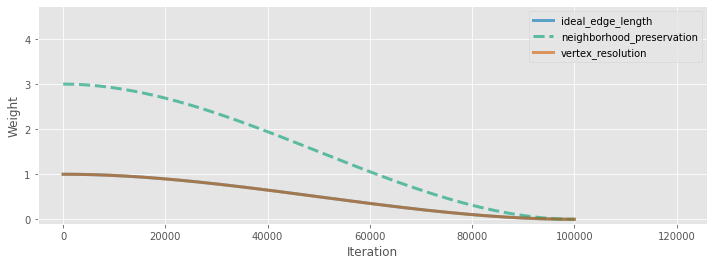

In [12]:

# criteria = ['stress']
# criteria_weights = dict(
#     stress=ws.SmoothSteps([max_iter/4, max_iter], [1, 0.0]),
# )

# criteria = ['stress','ideal_edge_length']
# criteria_weights = dict(
#     stress=ws.SmoothSteps([max_iter/4, max_iter], [1, 0.0]),
#     ideal_edge_length=ws.SmoothSteps([0, max_iter/5, max_iter/5*3, max_iter], [0,0,1,0]),
# )

# criteria = ['neighborhood_preservation']
# criteria_weights = dict(
#     neighborhood_preservation=ws.SmoothSteps([max_iter/4, max_iter], [10, 0.0]),
# )

# criteria = ['stress', 'neighborhood_preservation']
# criteria_weights = dict(
#     stress=ws.SmoothSteps([max_iter*0.25, max_iter*0.75, max_iter], [1, 0.0, 0.0]),
#     neighborhood_preservation=ws.SmoothSteps([0, max_iter*0.67, max_iter*0.67+1, max_iter], [0, 0.0, 5, 0.0]),
# )

# criteria = ['stress', 'crossings']
# criteria_weights = dict(
#     stress=ws.SmoothSteps([max_iter/4, max_iter], [1, 0.1]),
#     crossings=ws.SmoothSteps([max_iter/5*3, max_iter/5*4, max_iter/5*4+1, max_iter], [0, 0, 0.2, 0]),
# #     crossings=SmoothSteps([max_iter*0.5, max_iter*0.6, max_iter], [0, 0, 0.1]), ## for dodecahedron
# )


# criteria = {'stress', 'ideal_edge_length', 'angular_resolution'}
# criteria_weights = dict(
#     stress=ws.SmoothSteps([max_iter/4, max_iter], [1, 0.0]),
#     ideal_edge_length=ws.SmoothSteps([0, max_iter*0.2, max_iter*0.6, max_iter], [0, 0, 0.2, 0]),
#     angular_resolution=ws.SmoothSteps([0, max_iter*0.5, max_iter*0.75, max_iter], [0, 0, 0.5, 0]),
# )

# criteria = {'stress', 'vertex_resolution'}
# criteria_weights = dict(
#     stress=ws.SmoothSteps([max_iter/4, max_iter], [1, 0.0]),
#     vertex_resolution=ws.SmoothSteps([0, max_iter*0.5, max_iter*0.75, max_iter], [0, 0, 0.5, 0]),
# )

# criteria = {'stress', 'gabriel'}
# # criteria_weights = dict(
# #     stress=ws.SmoothSteps([max_iter/4, max_iter], [1, 0.0]),
# #     gabriel=ws.SmoothSteps([0, max_iter*0.5, max_iter*0.75, max_iter], [0, 0, 0.3, 0]),
# # )

# criteria = ['stress', 'crossing_angle_maximization']
# criteria_weights = dict(
#     stress=ws.SmoothSteps([0, max_iter*0.9, max_iter], [1, 0, 0]),
#     crossing_angle_maximization=ws.SmoothSteps([0, max_iter*0.6, max_iter*0.6+1, max_iter], [0, 0, 0.5 0.05]),
# )


# criteria = ['stress', 'aspect_ratio']
# criteria_weights = dict(
#     stress=ws.SmoothSteps([max_iter/4, max_iter], [1, 0.05]),
#     aspect_ratio=ws.SmoothSteps([0, max_iter*0.2, max_iter*0.6, max_iter], [0, 0, 1, 0]),
# )

# criteria = ['stress', 'ideal_edge_length', 'aspect_ratio']
# criteria_weights = dict(
#     stress=ws.SmoothSteps([max_iter/4, max_iter], [1, 0.05]),
#     ideal_edge_length=ws.SmoothSteps([0, max_iter*0.2, max_iter*0.6, max_iter], [0, 0, 0.2, 0]),
#     aspect_ratio=ws.SmoothSteps([0, max_iter*0.2, max_iter*0.6, max_iter], [0, 0, 0.5, 0]),
# )

## =============doing===============

criteria = ['ideal_edge_length', 'neighborhood_preservation', 'vertex_resolution']
criteria_weights = dict(
    stress=ws.SmoothSteps([max_iter*0.25, max_iter*0.75, max_iter], [1, 0.0, 0.0]),
    ideal_edge_length=ws.SmoothSteps([0,max_iter], [1, 0]),
    neighborhood_preservation=ws.SmoothSteps([0, max_iter], [3, 0.0]),
    vertex_resolution=ws.SmoothSteps([0, max_iter], [1, 0]),
)

# criteria = {'angular_resolution'}
# criteria_weights = dict(
#     stress=ws.SmoothSteps([max_iter/4, max_iter], [10, 0.0]),
#     angular_resolution=ws.SmoothSteps([0, max_iter], [1, 0]),
# )

# criteria = {'vertex_resolution'}
# criteria_weights = dict(
#     stress=ws.SmoothSteps([max_iter/4, max_iter], [10, 0.0]),
# #     vertex_resolution=ws.SmoothSteps([0, max_iter*0.5, max_iter*0.75, max_iter], [0, 0, 0.5, 0]),
#     vertex_resolution=ws.SmoothSteps([0, max_iter], [1, 0]),
# )


# criteria = ['crossings', 'crossing_angle_maximization']
# criteria_weights = dict(
#     ideal_edge_length=ws.SmoothSteps([0, max_iter*0.2, max_iter*0.6, max_iter], [0, 0.4, 0.2, 0]),
#     crossings=ws.SmoothSteps([0, max_iter], [1, 0]),
#     crossing_angle_maximization=ws.SmoothSteps([0, max_iter*0.6, max_iter*0.6+1, max_iter], [0, 0, 0.5, 0.01]),
# )


# criteria = ['crossing_angle_maximization']
# criteria_weights = dict(
#     crossing_angle_maximization=ws.SmoothSteps([0, max_iter], [1, 0.0]),
# )


# criteria = ['stress', 'crossings', 'crossing_angle_maximization']
# criteria_weights = dict(
#     stress=ws.SmoothSteps([max_iter/4, max_iter], [0.6, 0.05]),
#     crossings=ws.SmoothSteps([0, max_iter*0.2, max_iter*0.5, max_iter], [0, 0, 0.01, 0]),
#     crossing_angle_maximization=ws.SmoothSteps([0, max_iter*0.75, max_iter*0.75+1, max_iter], [0, 0, 0.2, 0]),
# )


## =============todo===============

# criteria = {'gabriel'}
# criteria_weights = dict(
#     stress=ws.SmoothSteps([0, max_iter*0.9, max_iter], [1, 0.05, 0.05]),
#     neighborhood_preservation=ws.SmoothSteps([0, max_iter*0.6, max_iter*0.6+1,  max_iter], [0, 0, 0.5, 0.0]),
# #     gabriel=ws.SmoothSteps([0, max_iter*0.5, max_iter*0.75, max_iter], [0, 0, 0.8, 0]),
#     gabriel=ws.SmoothSteps([0, max_iter], [0.8, 0]),
# )

# criteria = ['crossings', 'crossing_angle_maximization']
# criteria_weights = dict(
#     crossings=ws.SmoothSteps([0,max_iter*0.5, max_iter], [0.0001, 0.1, 0]),
# #     crossing_angle_maximization=ws.SmoothSteps([0, max_iter], [0.2, 0]),
#     crossing_angle_maximization=ws.SmoothSteps([0, max_iter*0.6, max_iter*0.6+1, max_iter], [0, 0, 0.2, 0]),
# )

# criteria = ['neighborhood_preservation', 'crossing_angle_maximization', 'angular_resolution']
# criteria_weights = dict(
#     neighborhood_preservation=ws.SmoothSteps([0, max_iter], [1, 0.0]),
# #     crossings=ws.SmoothSteps([max_iter/4, max_iter], [1, 0.1]),
#     crossing_angle_maximization=ws.SmoothSteps([0, max_iter*0.6, max_iter*0.6+1, max_iter], [0, 0, 0.2, 0]),
#     angular_resolution=ws.SmoothSteps([0, max_iter*0.4, max_iter*0.4+1, max_iter], [0, 0, 0.2, 0]),
# )

# criteria = {'gabriel'}
# criteria_weights = dict(
#     gabriel=ws.SmoothSteps([max_iter/4, max_iter], [1, 0.0]),
# )




# # old constant weights
# criteria_weights = dict(
#     stress=1,
# ideal_edge_length=0.2,
# neighborhood_preservation=0.2,
# #     crossings=0.2,
# #     crossing_angle_maximization=0.1,
# #     aspect_ratio=3,
# #     angular_resolution=1,
# #     vertex_resolution=1,
# #     gabriel=0.1,    
# )





criteria_weights = {c:criteria_weights[c] for c in criteria}
plot_weight(criteria_weights, max_iter)

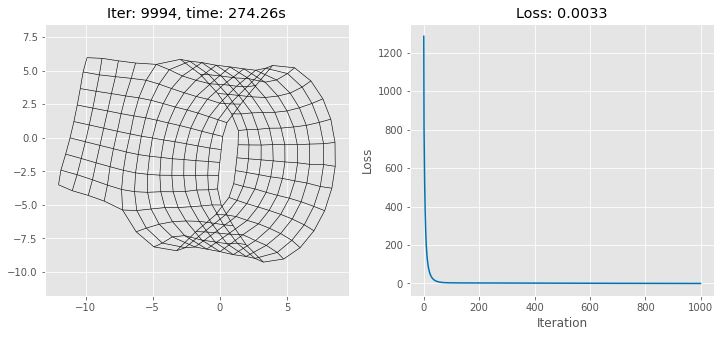

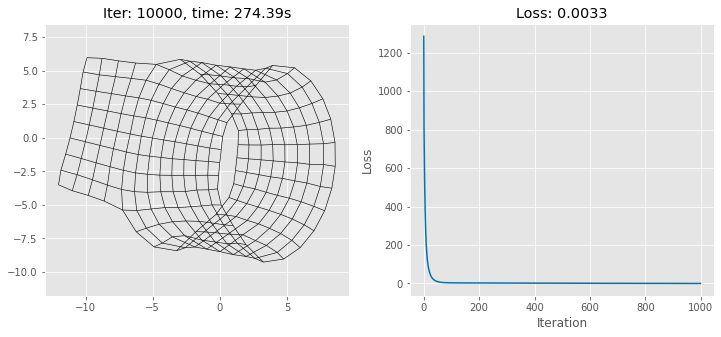

./layouts/grid1-ideal_edge_length+neighborhood_preservation+vertex_resolution.pkl
CPU times: user 2h 22min 27s, sys: 1min 13s, total: 2h 23min 41s
Wall time: 48min 11s


In [17]:
%%time


import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2

mat_dir = 'input_graphs/SuiteSparse Matrix Collection'
for graph_name, G, max_iter in [
    ('tree_2_6', nx.balanced_tree(2,6), int(10e4)),
    ('grid_12_24', nx.grid_2d_graph(12,24), int(1e5)),
    ('spx_teaser', utils.load_spx_teaser(), int(1e5)),
    ('dodecahedron', nx.dodecahedral_graph(), int(3e4)),
    ('dwt_307', utils.load_mat(f'{mat_dir}/dwt_307.mat'), int(10e4)),
    ('494_bus', utils.load_mat(f'{mat_dir}/494_bus.mat'), int(20e4)),
    ('dwt_1005', utils.load_mat(f'{mat_dir}/dwt_1005.mat'), int(20e4)),
    ('grid1', utils.load_mat(f'{mat_dir}/grid1.mat'), int(10e4)),
]:
    print(graph_name)
    
    
    
    ### criteria
#     criteria = ['stress', 'aspect_ratio']
#     criteria_weights = dict(
#         stress=ws.SmoothSteps([max_iter/4, max_iter], [1, 0.05]),
#         aspect_ratio=ws.SmoothSteps([0, max_iter*0.2, max_iter*0.5, max_iter], [0, 0, 1, 0]),
#     )
    
#     criteria = {'stress', 'ideal_edge_length', 'angular_resolution'}
#     criteria_weights = dict(
#         stress=ws.SmoothSteps([max_iter/4, max_iter], [1, 0.0]),
#         ideal_edge_length=ws.SmoothSteps([0, max_iter*0.2, max_iter*0.6, max_iter], [0, 0, 0.2, 0]),
#         angular_resolution=ws.SmoothSteps([0, max_iter*0.5, max_iter*0.75, max_iter], [0, 0, 0.5, 0]),
#     )
    
#     criteria = {'stress', 'vertex_resolution'}
#     criteria_weights = dict(
#         stress=ws.SmoothSteps([max_iter/4, max_iter], [1, 0.0]),
#         vertex_resolution=ws.SmoothSteps([0, max_iter*0.5, max_iter*0.75, max_iter], [0, 0, 1, 0]),
#     )
    
#     criteria = {'stress', 'gabriel'}
#     criteria_weights = dict(
#         stress=ws.SmoothSteps([max_iter/4, max_iter], [1, 0.0]),
#         gabriel=ws.SmoothSteps([0, max_iter*0.5, max_iter*0.75, max_iter], [0, 0, 0.3, 0]),
#     )

#     criteria = ['stress', 'crossing_angle_maximization']
#     criteria_weights = dict(
#         stress=ws.SmoothSteps([0, max_iter*0.9, max_iter], [1, 0, 0]),
#         crossing_angle_maximization=ws.SmoothSteps([0, max_iter*0.6, max_iter*0.6+1, max_iter], [0, 0, 0.5, 0.05]),
#     )
    
    
    max_iter = int(max_iter/10)
    criteria = ['ideal_edge_length', 'neighborhood_preservation', 'vertex_resolution']
    criteria_weights = dict(
        ideal_edge_length=ws.SmoothSteps([0,max_iter], [1, 0]),
        neighborhood_preservation=ws.SmoothSteps([0, max_iter], [3, 0.0]),
        vertex_resolution=ws.SmoothSteps([0, max_iter], [1, 0]),
    )

    
    
    
    
    seed = 1337
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


    sample_sizes = dict(
    #     stress=128,
    #     stress=1,
        stress=16,
    #     ideal_edge_length=32,
        ideal_edge_length=16,
        neighborhood_preservation=16,
        crossings=128,
        crossing_angle_maximization=16,
        aspect_ratio=max(128, int(len(G)**0.5)),
        angular_resolution=128,
        vertex_resolution=int(len(G)**0.5),
        gabriel=64,
    )
    sample_sizes = {c:sample_sizes[c] for c in criteria}



    
    
    
    gd = GD2(G)
    result = gd.optimize(
        criteria_weights=criteria_weights, 
    #     criteria_weights=criteria_weights, ## all criteria
        sample_sizes=sample_sizes,

        evaluate='all',
    #     evaluate=criteria,

        max_iter=max_iter,
        time_limit=600, ##sec

        evaluate_interval=60, evaluate_interval_unit='sec',
        vis_interval=3, vis_interval_unit='sec',
        clear_output=True,
        
        grad_clamp=20,
        criteria_kwargs = dict(
            aspect_ratio=dict(target=[1,1]),
        ),
        optimizer_kwargs = dict(mode='SGD', lr=2),
    #     optimizer_kwargs = dict(mode='Adam', lr=0.1),

        scheduler_kwargs = dict(verbose=True),
    )

    pos = gd.pos.detach().numpy()
    pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
    vis.plot(
        gd.G, pos_G,
        gd.loss_curve, 
        result['iter'], result['runtime'],
        show=True, save=False,
        node_size=0,
        edge_width=0.6,
    )
    
    
    
    ## dump result
    pos = gd.pos.detach().numpy()
    pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
    result_dict = dict(
        graph_name=graph_name,
        pos_G = pos_G,
        G = gd.G,
        criteria_weights = criteria_weights,
        criteria = criteria,
        sample_sizes = sample_sizes,
        loss_curve = gd.loss_curve,
        max_iter=max_iter,
    )
    
    
    fn = f'./layouts/{graph_name}-{"+".join(criteria)}.pkl'
    print(fn)
    with open(fn, 'wb') as f:
        pkl.dump(result_dict, f)
    
    
    



In [ ]:

t = [r['time'] for r in gd.qualities_by_time]

for k in criteria:
    quality_curve = [r['qualities'][k] for r in gd.qualities_by_time]
    plt.figure(figsize=False[8,4])
    plt.plot(t, quality_curve, '.-')
    plt.title(f'{k}: {quality_curve[-1]}')
    plt.xlabel('Time')
    plt.ylabel('Quality')
    plt.show()


    
if len(criteria)==2:
    qx, qy = criteria
    quality_curve_x = [r['qualities'][qx] for r in gd.qualities_by_time]
    quality_curve_y = [r['qualities'][qy] for r in gd.qualities_by_time]

    plt.figure()
    plt.plot(quality_curve_x, quality_curve_y, '-', c='#777777', zorder=-1)
    plt.scatter(quality_curve_x, quality_curve_y, c=np.arange(len(quality_curve_x)))
    plt.xlabel(qx)
    plt.ylabel(qy)
    plt.xlim([0, max(max(quality_curve_x), 1.1)])
    plt.ylim([0, max(max(quality_curve_y)*1.05, 1.1)])


## Draw saved result

In [ ]:
fns = natsorted(glob('./layouts/*.pkl'))
len(fns), fns[-12:]

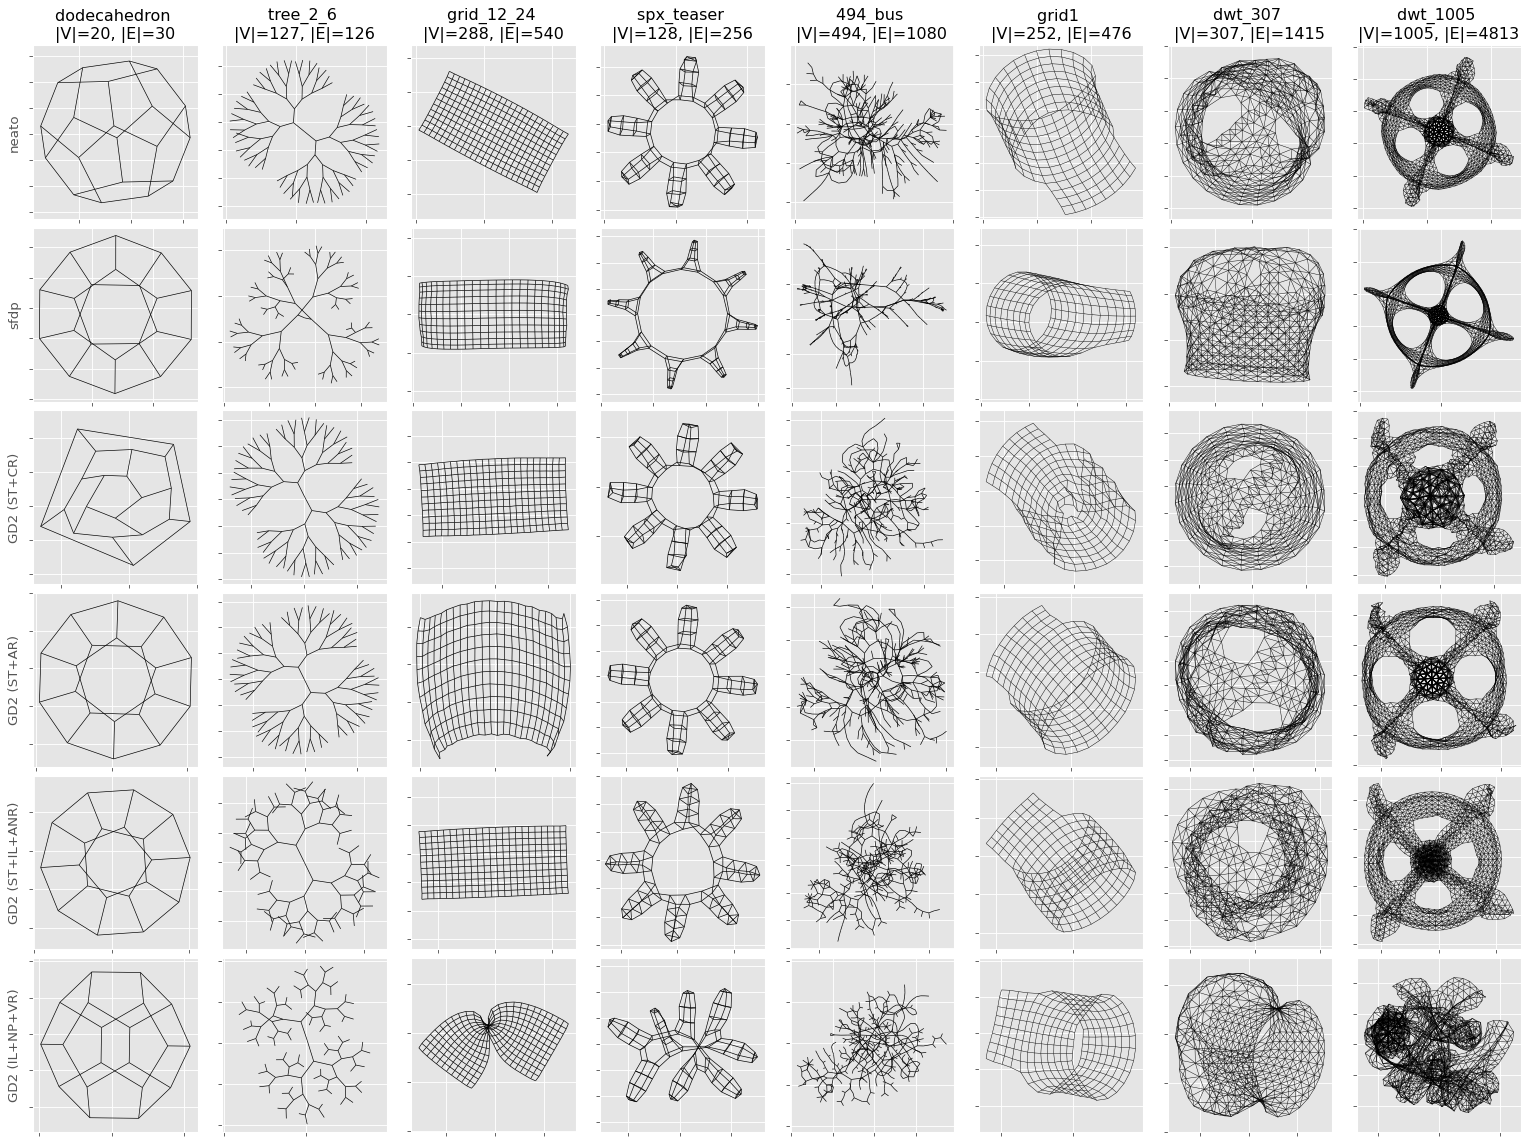

In [123]:
from utils.weight_schedule import SmoothSteps, Concat, SmoothStepSchedule
    
methods = [
    ('neato', 'neato'),
    ('sfdp', 'sfdp'),
    
#     ('GD2 (ST)', 'stress'),
#     ('GD2 (NP)', 'neighborhood_preservation'),
    
#     ('GD2 (ST+IL)', 'stress+ideal_edge_length'),
#     ('GD2 (ST+NP)', 'stress+neighborhood_preservation'),
    ('GD2 (ST+CR)', 'stress+crossings'),
#     ('GD2 (ST+CAM)', 'stress+crossing_angle_maximization'),
    ('GD2 (ST+AR)', 'stress+aspect_ratio'),
#     ('GD2 (ST+VR)',     'stress+vertex_resolution'),
#     ('GD2 (ST+GB)',     'stress+gabriel'),
    
    ('GD2 (ST+IL+ANR)', 'stress+ideal_edge_length+angular_resolution'),
    ('GD2 (IL+NP+VR)',  'ideal_edge_length+neighborhood_preservation+vertex_resolution'),
    
]

graphs = ['dodecahedron', 'tree_2_6', 'grid_12_24', 'spx_teaser', '494_bus', 'grid1', 'dwt_307', 'dwt_1005']

fig = plt.figure(figsize=[len(graphs)*3, len(methods)*3], dpi=80)
gs = GridSpec(len(methods),len(graphs), hspace=0.05, wspace=0.15)

for (i, (method_short, method)), (j,graph) in itertools.product(enumerate(tqdm(methods)), enumerate(graphs)):
    fn = f'./layouts/{graph}-{method}.pkl'
    with open(fn, 'rb') as f:
        result_dict = pkl.load(f)
    G = result_dict.get('G')
    pos = result_dict.get('pos_G')
    criteria_weights = result_dict.get('criteria_weights')
    max_iter = result_dict.get('max_iter', 20e5)
    
    graph_name = fn.split('/')[-1].split('-')[0]
#     criteria_str = fn.split('/')[-1].split('-')[1].split('.pkl')[0]
    title = f'{graph_name} \n|V|={len(G)}, |E|={len(G.edges)}' if i == 0 else ''
    ylabel = f'{method_short}' if j == 0 else ''
    
    
    ax = fig.add_subplot(gs[i,j])
    vis.draw_graph(G, pos, ax, edge_width=0.6 if j<=4 else 0.4)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.axis('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
#     ax2 = fig.add_subplot(gs[1,0])
#     plot_weight(criteria_weights, max_iter, ax2)
    
plt.savefig('all-drawings-2-partial.png', dpi=90, bbox_inches='tight')
plt.show()


## Measure the quality of saved results

In [21]:
fns = natsorted(glob('./layouts/*.pkl'))
fns

['./layouts/494_bus-ideal_edge_length+neighborhood_preservation+vertex_resolution.pkl',
 './layouts/494_bus-neato.pkl',
 './layouts/494_bus-neighborhood_preservation.pkl',
 './layouts/494_bus-sfdp.pkl',
 './layouts/494_bus-stress+aspect_ratio.pkl',
 './layouts/494_bus-stress+crossing_angle_maximization.pkl',
 './layouts/494_bus-stress+crossings.pkl',
 './layouts/494_bus-stress+gabriel.pkl',
 './layouts/494_bus-stress+ideal_edge_length+angular_resolution.pkl',
 './layouts/494_bus-stress+ideal_edge_length.pkl',
 './layouts/494_bus-stress+neighborhood_preservation.pkl',
 './layouts/494_bus-stress+vertex_resolution.pkl',
 './layouts/494_bus-stress.pkl',
 './layouts/dodecahedron-ideal_edge_length+neighborhood_preservation+vertex_resolution.pkl',
 './layouts/dodecahedron-neato.pkl',
 './layouts/dodecahedron-neighborhood_preservation.pkl',
 './layouts/dodecahedron-sfdp.pkl',
 './layouts/dodecahedron-stress+aspect_ratio.pkl',
 './layouts/dodecahedron-stress+crossing_angle_maximization.pkl',
 '

In [22]:
import pandas as pd

In [23]:
import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2

In [28]:
%%time

criteria_all = [
    'stress',
    'ideal_edge_length',
    'neighborhood_preservation',
    'crossings',
    'crossing_angle_maximization',
    'aspect_ratio',
    'angular_resolution',
    'vertex_resolution',
    'gabriel',
]

quality_tables = {c:[
    [utils.criterion_to_title(c)],
    ['', *[g.replace('_', '-') for g in graphs]], 
    *[[ms[0]] for ms in methods]] 
    for c in criteria_all
}

for (i, (method_short, method)), (j,graph) in tqdm(list(itertools.product(enumerate(methods), enumerate(graphs)))):
    print(method, graph)
    
    fn = f'./layouts/{graph}-{method}.pkl'
    with open(fn, 'rb') as f:
        result_dict = pkl.load(f)
    G = result_dict.get('G')
    pos_G = result_dict.get('pos_G')
    gd = GD2(G)
    pos = torch.tensor([pos_G[gd.i2k[i]] for i in range(len(G))])
    
    ## TODO give 'full advantange' to neato and sfdp
    ## on stress and ideal_edge_length
    if method in {'neato', 'sfdp'}:
        qualities = gd.evaluate(pos, qualities=criteria_all, mode='best_scale')
#         print(qualities['stress'], qualities['ideal_edge_length'])
    else:
        qualities = gd.evaluate(pos, qualities=criteria_all, mode='original')
    for c,q in qualities.items():
#         quality_tables[c][i+2].append(float(f'{q:.2f}'))
        quality_tables[c][i+2].append(q)


neato dodecahedron
neato tree_2_6
neato grid_12_24
neato spx_teaser
neato 494_bus
neato grid1
neato dwt_307
neato dwt_1005
sfdp dodecahedron
sfdp tree_2_6
sfdp grid_12_24
sfdp spx_teaser
sfdp 494_bus
sfdp grid1
sfdp dwt_307
sfdp dwt_1005
stress dodecahedron
stress tree_2_6
stress grid_12_24
stress spx_teaser
stress 494_bus
stress grid1
stress dwt_307
stress dwt_1005
neighborhood_preservation dodecahedron
neighborhood_preservation tree_2_6
neighborhood_preservation grid_12_24
neighborhood_preservation spx_teaser
neighborhood_preservation 494_bus
neighborhood_preservation grid1
neighborhood_preservation dwt_307
neighborhood_preservation dwt_1005
stress+ideal_edge_length dodecahedron
stress+ideal_edge_length tree_2_6
stress+ideal_edge_length grid_12_24
stress+ideal_edge_length spx_teaser
stress+ideal_edge_length 494_bus
stress+ideal_edge_length grid1
stress+ideal_edge_length dwt_307
stress+ideal_edge_length dwt_1005
stress+neighborhood_preservation dodecahedron
stress+neighborhood_preserv

In [29]:
fn = f'analysis/quality/quality_tables-t{int(time.time())}.pkl'
with open(fn, 'wb') as f:
    pkl.dump(quality_tables, f)
print(fn)

analysis/quality/quality_tables-t1636491208.pkl


In [115]:
# with open('analysis/quality/quality_tables-t1636265195.pkl', 'rb') as f:
# with open('analysis/quality/quality_tables-t1636398120.pkl', 'rb') as f:
# with open('analysis/quality/quality_tables-t1636399506.pkl', 'rb') as f:
with open('analysis/quality/quality_tables-t1636491208.pkl', 'rb') as f:
    quality_tables = pkl.load(f)


In [116]:
for c,t in quality_tables.items():
    t[1][0] = 'methods \\textbackslash~graphs'
    
    
    values = np.array([r[1:] for r in t[2:]])
    best_indices = values.argmin(axis=0)
    best_values = values.min(axis=0)
    for j in range(len(graphs)):
        best_value = t[best_indices[j]+2][j+1]
        for i in range(len(methods)):
            value = t[i+2][j+1]
            if c == 'crossings':
                if abs(value-best_value) < 1:# \
                    t[i+2][j+1] = f'**{value:d}**'
                    t[i+2][j+1] = f'\\textbf{{{value:d}}}'
                else:
                    t[i+2][j+1] = f'{value:d}'
                    
            else:
                if abs(value-best_value) < 0.001:# \
#                     t[i+2][j+1] = f'**{value:.3f}**'
                    t[i+2][j+1] = f'\\textbf{{{value:.3f}}}'
                else:
                    t[i+2][j+1] = f'{value:.3f}'


In [119]:
from IPython.display import HTML, display
import tabulate

for c,t in quality_tables.items():
#     display(HTML(tabulate.tabulate(t, tablefmt='html')))
#     display(HTML(tabulate.tabulate(t, tablefmt='latex_raw')))
    print(f'%% ==== {c} ====')
    print('\\begin{table}[h]')
    latex_table = tabulate.tabulate(t[1:], tablefmt='latex_raw').replace('lllllllll', 'l|rrrrrrrr')
    latex_table_list = latex_table.split('\n')
    latex_table_list.insert(3, '\\hline')
    latex_table = '\n'.join(latex_table_list)
    print(latex_table)
    print(f'\\caption{{Quality Measures of {utils.criterion_to_title(c)}}}')
    print(f'\\label{{tab:quality-table-{c}}}')
    print('\\end{table}')
    
    print(f'\n\n')


%% ==== stress ====
\begin{table}
\begin{tabular}{l|rrrrrrrr}
\hline
 methods \textbackslash~graphs & dodecahedron   & tree-2-6       & grid-12-24     & spx-teaser     & 494-bus        & grid1          & dwt-307        & dwt-1005       \\
\hline
 neato                         & 0.081          & \textbf{0.078} & \textbf{0.013} & \textbf{0.027} & 0.076          & \textbf{0.062} & 0.083          & \textbf{0.021} \\
 sfdp                          & \textbf{0.080} & 0.133          & 0.024          & 0.052          & 0.099          & 0.071          & \textbf{0.081} & 0.029          \\
 GD2 (ST)                      & \textbf{0.079} & \textbf{0.078} & \textbf{0.013} & \textbf{0.027} & \textbf{0.071} & \textbf{0.062} & 0.082          & \textbf{0.022} \\
 GD2 (NP)                      & 0.188          & 0.233          & 0.065          & 0.241          & 0.825          & 0.149          & 0.279          & 0.275          \\
 GD2 (ST+IL)                   & 0.107          & 0.100          & 0.033  

In [ ]:
# from IPython.display import HTML, display
# import tabulate
# table = [["Sun"],
#          ["Earth",6371,5973.6],
#          ["Moon",1737,73.5],
#          ["Mars",3390,641.85]]


## Example matrix

In [ ]:
# !mkdir -p ./analysis/pairs

In [ ]:
# ##DONE move it to GD2.py

# import pickle as pkl

# def dump(gd, fn='result.pkl'):
#     with open(fn, 'wb') as f:
#         pkl.dump(dict(
#             G=gd.G,
#             pos=gd.pos,
#             i2k=gd.i2k,
#             k2i=gd.k2i,
#             iter=gd.i,
#             runtime=gd.runtime,
#             loss_curve=gd.loss_curve,
#             qualities_by_time = gd.qualities_by_time,
#         ), f)

In [ ]:
##choose a graph
# G = nx.balanced_tree(2,5)
# graph_str = 'tree_2_5'

G = nx.grid_2d_graph(5,8)
graph_str = 'grid_5_8'

start_date = int(time.time())
dir_out = f'./analysis/criteria_pairs/{graph_str}-t{start_date}'
print(dir_out)
if not Path(dir_out).exists():
    os.makedirs(dir_out)

In [ ]:
%%time


import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2









criteria_weights = dict(
    stress=1,
    ideal_edge_length=0.5,
    neighborhood_preservation=0.5,
    crossings=1,
    crossing_angle_maximization=0.1,
    aspect_ratio=10,
    angular_resolution=0.1,
    vertex_resolution=0.05,
    gabriel=0.5,
)

sample_sizes = dict(
    stress=64,
    neighborhood_preservation=16,
    crossings=16,
    crossing_angle_maximization=10,
    aspect_ratio=int(len(G)**0.5),
    angular_resolution=32,
    vertex_resolution=int(len(G)**0.5),
#     vertex_resolution=len(G),
    gabriel=10,
)




## choose criteria
criteria_all = [
    'stress',
    'ideal_edge_length',
    'neighborhood_preservation',
    'crossings',
    'crossing_angle_maximization',
    'aspect_ratio',
    'angular_resolution',
    'vertex_resolution',
    'gabriel',
]

criteria_pairs = [
    (ci, cj) for (i,ci), (j, cj) 
    in list(
        itertools.product(
            enumerate(criteria_all), 
            enumerate(criteria_all)
        ))
    if i<=j
]


for c1, c2 in tqdm(criteria_pairs):
    criteria_pair = {c1,c2}
    print(criteria_pair)

    gd = GD2(G)

    result = gd.optimize(
        criteria_weights={c:criteria_weights[c] for c in criteria_pair}, 
        sample_sizes=sample_sizes,
        evaluate=criteria_all,

        max_iter=100, 
        evaluate_interval=10000//40,
        vis_interval=-10000//10,
#             clear_output=True,

        optimizer_kwargs = dict(lr=2),
        scheduler_kwargs = dict(verbose=False),
    )
    print(result['qualities'])

    pos = gd.pos.detach().numpy()
    pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
    vis.plot(
        gd.G, pos_G,
        gd.loss_curve, 
        result['iter'], result['runtime'],
        edge=True, show=True, save=False
    )



    ## store data
    if c1 == c2:
        fn = c1
    else:
        fn = f'{c1}-vs-{c2}'
    gd.save(f'{dir_out}/{fn}.pkl')




## plot examples in a matrix

In [ ]:
import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2

In [ ]:
from matplotlib.gridspec import GridSpec

In [ ]:
# dir_in = './analysis/criteria_pairs/tree_2_6-0'
# dir_in = './analysis/criteria_pairs/tree_2_5-t1633627830'
# dir_in = './analysis/criteria_pairs/tree_2_5-t1633999851'

dir_in_left = './analysis/criteria_pairs/tree_2_5-t1634182253'
dir_in_upper = './analysis/criteria_pairs/grid_5_8-t1634182400'

criteria_all = [
    'stress',
    'ideal_edge_length',
    'neighborhood_preservation',
    'crossings',
    'crossing_angle_maximization',
    'aspect_ratio',
    'angular_resolution',
    'vertex_resolution',
    'gabriel',
]
n = len(criteria_all)


# mode = 'criteria_pairs'
mode = 'drawings'
# mode = 'learning_curves'


dpi = 120
if mode == 'drawings':
    space = 0.2
    figsize = [35,35]
else:
    space = 0.3
    figsize = [40,40]
    
fig = plt.figure(figsize=figsize, dpi=dpi)
gs = GridSpec(n,n, wspace=space, hspace=space)

criteria_pairs = list(itertools.product(enumerate(criteria_all), enumerate(criteria_all)))

for (i,c1), (j,c2) in tqdm(criteria_pairs):
    
        if c1 == c2:
            fn = c1
        elif i<j:
            fn = f'{c1}-vs-{c2}'
        elif i>j:
            fn = f'{c2}-vs-{c1}'
            
        with open(f'{dir_in}/{fn}.pkl', 'rb') as f:
            data = pkl.load(f)
#             ax = plt.subplot(gs[(n-1)-i,j])
            ax = plt.subplot(gs[i,j])
            
            if mode == 'drawings':
                ## draw graphs
                pos = data['pos'].detach().numpy()
                pos_G = {k:pos[data['k2i'][k]] for k in data['G'].nodes}
                vis.draw_graph(
                    data['G'], pos_G, ax=ax,
                    ylabel=c1,# if j==0 else '',
                    xlabel=c2,# if i==0 else '',
                )
                ax.xaxis.set_label_position('top')
                plt.axis('equal')
                ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            
            
            elif mode == 'criteria_pairs':
                ## plot learn curves
                t = [r['time'] for r in data['qualities_by_time']]
                quality_curve_x = [r['qualities'][c2] for r in data['qualities_by_time']]
                quality_curve_y = [r['qualities'][c1] for r in data['qualities_by_time']]
                plt.scatter(quality_curve_x, quality_curve_y, s=50, c=t)
                plt.xlabel(c2)
                plt.ylabel(c1)
                
                
            elif mode == 'learning_curves':
                ## plot quality curves       
                t = [r['time'] for r in data['qualities_by_time']]
                for c in criteria_all:
                    quality_curve = np.array([r['qualities'][c] for r in data['qualities_by_time']])
                    if c in {'stress', 'crossings', 'ideal_edge_length'}:
                        quality_curve = quality_curve/quality_curve.max()
                        
                    if c == c1:
                        color, alpha, style = 'C0', 1.0, '-'
                    elif c == c2:
                        color, alpha, style = 'C1', 1.0, '-'
                    else:
                        color, alpha, style = '#aaa', 1.0, '-'
                    plt.plot(
                        t, quality_curve, 
                        style, 
                        label=c if c==c1 or c==c2 else None,
                        lw=2 if c==c1 or c==c2 else 0.5,
                        color=color,
                        alpha=alpha
                    )
                plt.xlabel('Time')
                plt.ylabel('Quality')
#                 plt.title(f'{c1} vs. {c2}')
                plt.legend()
                plt.ylim([-0.1, 1.5])

t = dir_in.split('-')[-1]
plt.savefig(f'{mode}-matrix-{t}.png', bbox_inches='tight', dpi=dpi)
plt.show()
            


## testing reyans hyper cubes

In [ ]:
import json
log_dir = 'reyan/log_folder/'
problematic_files = ['input_11.txt', 'input_18.txt', 'input_26.txt', 'input_27.txt', 'input_28.txt', 'input_48.txt', 'input_56.txt', 'input_63.txt', 'input_70.txt', 'input_71.txt', 'input_73.txt', 'input_74.txt', 'input_75.txt', 'input_76.txt', 'input_93.txt', 'input_94.txt', 'input_95.txt', 'input_101.txt', 'input_102.txt', 'input_103.txt', 'input_108.txt', 'input_109.txt', 'input_110.txt', 'input_115.txt', 'input_116.txt', 'input_117.txt', 'input_118.txt', 'input_120.txt', 'input_121.txt', 'input_122.txt', 'input_123.txt', 'input_124.txt', 'input_125.txt', 'input_126.txt', 'input_127.txt', 'input_128.txt', 'input_129.txt', 'input_134.txt', 'input_137.txt', 'input_138.txt', 'input_139.txt', 'input_140.txt', 'input_146.txt', 'input_147.txt', 'input_148.txt', 'input_153.txt', 'input_154.txt', 'input_155.txt', 'input_157.txt', 'input_160.txt', 'input_161.txt', 'input_162.txt', 'input_163.txt', 'input_164.txt', 'input_166.txt', 'input_167.txt', 'input_168.txt', 'input_169.txt', 'input_170.txt', 'input_171.txt', 'input_172.txt', 'input_173.txt', 'input_174.txt', 'input_179.txt', 'input_183.txt', 'input_184.txt', 'input_185.txt', 'input_191.txt', 'input_192.txt', 'input_193.txt', 'input_198.txt', 'input_199.txt', 'input_200.txt', 'input_202.txt', 'input_205.txt', 'input_206.txt', 'input_208.txt', 'input_209.txt', 'input_211.txt', 'input_212.txt', 'input_213.txt', 'input_214.txt', 'input_215.txt', 'input_216.txt', 'input_217.txt', 'input_218.txt', 'input_219.txt', 'input_224.txt']
pairs = []
for fn in problematic_files:
    with open(log_dir+fn) as f:
        params = json.load(f)
        graph_str = f'{params["graph"]} {params["graph_param_1"]}'
        pairs.append(
            (tuple(sorted(params['metrics'])),)
            +(graph_str,fn.split('/')[-1].split('.')[0])
        )
        
# for criteria, graph, fn in natsorted(pairs, key=lambda x:x[-1]):
for criteria, graph, fn in natsorted(pairs, key=lambda x:x):
    print(f'{graph}\t{fn:<12} {criteria} ')

In [ ]:
from pathlib import Path

In [ ]:
log_dir = 'log_folder/'
problematic_files = ['input_11.txt', 'input_18.txt', 'input_26.txt', 'input_27.txt', 'input_28.txt', 'input_48.txt', 'input_56.txt', 'input_63.txt', 'input_70.txt', 'input_71.txt', 'input_73.txt', 'input_74.txt', 'input_75.txt', 'input_76.txt', 'input_93.txt', 'input_94.txt', 'input_95.txt', 'input_101.txt', 'input_102.txt', 'input_103.txt', 'input_108.txt', 'input_109.txt', 'input_110.txt', 'input_115.txt', 'input_116.txt', 'input_117.txt', 'input_118.txt', 'input_120.txt', 'input_121.txt', 'input_122.txt', 'input_123.txt', 'input_124.txt', 'input_125.txt', 'input_126.txt', 'input_127.txt', 'input_128.txt', 'input_129.txt', 'input_134.txt', 'input_137.txt', 'input_138.txt', 'input_139.txt', 'input_140.txt', 'input_146.txt', 'input_147.txt', 'input_148.txt', 'input_153.txt', 'input_154.txt', 'input_155.txt', 'input_157.txt', 'input_160.txt', 'input_161.txt', 'input_162.txt', 'input_163.txt', 'input_164.txt', 'input_166.txt', 'input_167.txt', 'input_168.txt', 'input_169.txt', 'input_170.txt', 'input_171.txt', 'input_172.txt', 'input_173.txt', 'input_174.txt', 'input_179.txt', 'input_183.txt', 'input_184.txt', 'input_185.txt', 'input_191.txt', 'input_192.txt', 'input_193.txt', 'input_198.txt', 'input_199.txt', 'input_200.txt', 'input_202.txt', 'input_205.txt', 'input_206.txt', 'input_208.txt', 'input_209.txt', 'input_211.txt', 'input_212.txt', 'input_213.txt', 'input_214.txt', 'input_215.txt', 'input_216.txt', 'input_217.txt', 'input_218.txt', 'input_219.txt', 'input_224.txt']

for fn in problematic_files:
        
    with open(log_dir+fn) as json_file:
        input_param = json.load(json_file)
    
    graph_str = (
        input_param['graph']
        + ' ' 
        + ' '.join(input_param[k] for k in natsorted(input_param) if k.startswith('graph_param_'))
    )
    metrics = input_param['metrics']
    print(f'='*40)
    print(f'fn: {fn}')
    print(f'metrics: {metrics}')
    print(f'graph: {graph_str}')
    
    if Path(input_param["output_file"]).exists():
        continue
          
    print('generating graph', end=' ')
    if input_param["graph"]=="tree":
        G = nx.balanced_tree(int(input_param["graph_param_1"]), int(input_param["graph_param_2"]))
    elif input_param["graph"]=="hypercube":
        G = nx.hypercube_graph(int(input_param["graph_param_1"]))
    elif input_param["graph"]=="grid":
        dim = int(input_param["graph_param_1"])
        G = nx.grid_graph(dim = [dim, dim])
    print(f'of {len(G)} nodes')
    
    max_iter = 10000
    criteria_weights_default = {
        'stress': 4,
        'ideal_edge_length':1,
        'neighborhood_preservation':0.5,
        'crossings':1,
        'crossing_angle_maximization':0.1,
        'aspect_ratio':10,
        'angular_resolution':0.1,
        'vertex_resolution':1,
        'gabriel':0.01,
    }

    sample_sizes_default = {
        'stress': 64,
        'ideal_edge_length': 10,
        'neighborhood_preservation': 16,
        'crossings': 10,
        'crossing_angle_maximization':10,
        'aspect_ratio': 'full',
        'angular_resolution': 10,
        'vertex_resolution': int(len(G)**0.5),
        'gabriel': 10,
    }


    criteria_weights = {}
    for m in input_param['metrics']:
        criteria_weights[m] = criteria_weights_default[m]


    gd = GD2(G)
    result = gd.optimize(
        criteria_weights=criteria_weights,
        sample_sizes=sample_sizes_default,

        evaluate='all',
    #     evaluate={'neighborhood_preservation'},
#         evaluate=set(input_param['metrics']),

        max_iter=max_iter, 
        evaluate_interval=-1,
        vis_interval=-1,

        optimizer_kwargs = dict(lr=1),
        scheduler_kwargs = dict(verbose=False),
    )


    for q,v in result['qualities'].items():
        print(q,v)

    return_dict = dict(
        metric_value=result['qualities'],
        pos=result['pos'].detach().cpu().tolist(),
        time=result['runtime']
    )
    
    with open(input_param["output_file"], 'w') as fp:
        json.dump(return_dict, fp)
          
          
    ## vis for debugging
    pos = gd.pos.detach().numpy()
    pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
    vis.plot(
        gd.G, pos_G,
        gd.loss_curve, 
        result['iter'], result['runtime'],
        edge=True, show=True, save=False
    )

    

In [ ]:

# from utils import lovasz_losses as L
# a = torch.eye(5)
# pred = torch.randn(5,5)
# L.lovasz_softmax(pred, a)

## Analysis of sample size

In [ ]:
# import importlib
# importlib.reload(C)
# importlib.reload(Q)
# importlib.reload(utils)
# importlib.reload(vis)
# importlib.reload(gd2)

In [ ]:
import pandas as pd
import itertools

In [ ]:
df

In [ ]:
# cm = plt.cm.viridis()

# for result in results:
    
#     sample_size = result['sample_sizes']['stress']
    
#     t = [x['time'] for x in result['qualities_by_time']]
#     stress = [x['qualities']['stress'] for x in result['qualities_by_time']]
    
#     plt.plot(t, stress, '.-', label=f'sample_size = {sample_size}', color=cm(np.log2(sample_size)/np.log2(512)))
    
# plt.xlabel('Total Time (sec)')
# plt.ylabel('Stress')
# plt.yscale('log')

# plt.xlim([-10,100])
# plt.legend()
# plt.savefig('time-vs-stress-curve-by-sample-size-100sec.png')
# plt.show()

In [ ]:
# df.to_csv('./analysis/balanced-tree-2-8.csv')

In [ ]:
df.plot('sample_size', 'runtime', style='o')
df.plot('sample_size', 'stress', style='o');

In [ ]:
plt.scatter(
    df['runtime'], 
    df['stress'], 
    s=df['sample_size']+10, 
    linewidth=1,
    edgecolor='#eee',
    alpha=0.8,
#     c=df['sample_size']+10,
    label='Sample Size',
)

# plt.xscale('symlog')
plt.xlabel('Runtime')
plt.xlim([0, plt.xlim()[1]*1.1])

# plt.yscale('log')
plt.ylabel('Stress')
plt.ylim([0, plt.ylim()[1]*1.1])

plt.savefig('figures-tmp/runtime-vs-stress-by-sample_rate.png')

## Dev

In [ ]:
%%time


import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)


runtime = []

niter = int(1e6)

shouldVis = True
visIter = 5000

shouldSnap = True
snapIter = 5

gClamp = 4
minLR = 1e-5
maxSampleSize = 64


totalTime = 0

print('generating graph', end=' ')
# G = nx.grid_2d_graph(18,36)
# G = nx.hypercube_graph(3)
# G = nx.balanced_tree(2,4)
G = utils.load_spx_teaser()
# G = nx.karate_club_graph()


# graph_name = 'grid1'
# graph_name = 'grid1_dual'
# graph_name = 'odepa400'
# graph_name = 'netz4504_dual'
# graph_name = 'L'
# -----
# graph_name = 'netz4504'
# graph_name = 'qh882'
# mat_dir = 'graphs/SuiteSparse Matrix Collection'
# G = utils.load_mat(f'{mat_dir}/{graph_name}.mat')


# G = nx.Graph()
# G.add_nodes_from([0,1,2,3])
# G.add_edges_from([(0,1),(2,3)])




print(f'of {len(G)} nodes')
maxDegree = max(dict(G.degree).values())
print('Calculating all pairs shortest path', end='...')
t0 = time.time()

# D, k2i = utils.dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
# adj,_ = utils.dict2tensor(dict(G.adjacency()), fill=1, device=device)
D, adj_sparse, k2i = utils.shortest_path(G)
adj = torch.from_numpy(adj_sparse.toarray())
D = torch.from_numpy(D)

i2k = {i:k for k,i in k2i.items()}
edge_indices = [(k2i[e0], k2i[e1]) for e0,e1 in G.edges]
node_indices = range(len(G))
node_index_pairs = np.c_[
    np.repeat(node_indices, len(G)),
    np.tile(node_indices, len(G))
]
node_index_pairs_start = 0
np.random.shuffle(node_index_pairs)


    
dt = time.time() - t0
totalTime += dt

W = 1/(D**2+1e-6)
truth = adj + torch.eye(adj.shape[0], device=device)
print('done')


##training
#     pos = torch.rand(len(G.nodes), 2, device=device)*2-1
pos = torch.randn(len(G.nodes), 2, device=device)
pos.requires_grad_(True)


##LOAD prev layout
# G_ = nx.read_gpickle(glob(f'layouts/balanced_tree_{2}_{7}-stress-*.gpickle')[0])
# pos = {k2i[k]: G_.nodes[k]['pos'] for k in G_.nodes}
# pos = torch.stack([torch.from_numpy(pos[i]) for i in range(len(pos))])
# pos = pos.requires_grad_(True)


optimizer = optim.SGD([pos], lr=0.1, momentum=0.7, nesterov=True)
# optimizer = optim.RMSprop([pos], lr=0.01)
# optimizer = optim.Adam([pos], lr=0.001)


# scheduler = None
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.9, patience=np.ceil(np.log2(len(G)+1))*100, 
    min_lr=minLR, verbose=True
)
# scheduler = optim.lr_scheduler.LambdaLR(
#     optimizer, 
#     lr_lambda=lambda e:1*(1-e/niter)
# )


iterBar = tqdm(range(niter))
lossCurve = []
sampleSize = min(len(G), maxSampleSize)
degrees = adj.sum(1).numpy().astype(np.int64)
xPath = []

qualityMeasureInterval = max(1, niter // 30)
qualityMeasureCurves = defaultdict(list)
activeQualityMeasures = [
    'stress',
#     'ideal_edge_length',
#     'neighborhood_preservation',
#     'crossings',
    
#     'crossing_angle_maximization',
    'aspect_ratio',
#     'angular_resolution',
#     'vertex_resolution',
#     'gabriel',
    
]

for i in iterBar:
    t0 = time.time()
    
    ## optimization
    optimizer.zero_grad()

    if node_index_pairs_start >= len(node_index_pairs):
        np.random.shuffle(node_index_pairs)
        node_index_pairs_start = 0
    stress_samples = node_index_pairs[node_index_pairs_start:node_index_pairs_start+sampleSize]
    
    loss = (
        +C.stress(pos, D, W, samples=stress_samples)
#         +0.5*C.ideal_edge_length(pos, G, k2i, sampleSize-1)
#         +0.1*C.angular_resolution(pos, G, k2i, sampleSize=sampleSize//maxDegree)
#         + 10*C.aspect_ratio(pos, sampleSize)
#         C.crossing_angle_maximization(pos, G, k2i, i2k, sampleSize=10, sampleOn='crossings') ## slow for large sample size
#     +0.001*C.vertex_resolution(pos, sampleSize, target=1/len(G)**0.5)
#     + 0.1*C.gabriel(pos, G, k2i, sampleSize=int(sampleSize**0.5))
#         +1*C.crossings(pos, G, k2i, reg_coef=0.01, niter=20, sampleSize=4, sampleOn='crossings')
#         +C.crossings(pos, G, k2i, reg_coef=0.01, niter=20, sampleSize=20, sampleOn='edges')
#         C.neighborhood_preseration(pos, G, adj, k2i, i2k, n_roots=2, depth_limit=2)
    )
    loss.backward()
    pos.grad.clamp_(-gClamp, gClamp)
    optimizer.step()
    
    node_index_pairs_start+=sampleSize
    
    ## debug info
    totalTime += time.time() - t0
    if loss.isnan():
        raise Exception('loss is nan')
    if pos.isnan().any():
        raise Exception('pos is nan')
    
    if i % int(niter/100) == int(niter/100)-1:
        iterBar.set_postfix({'loss': loss.item(), })    
    if len(lossCurve) > 0:
        lossCurve.append(0.9*lossCurve[-1] + 0.1*loss.item())
    else:
        lossCurve.append(loss.item())
    if shouldSnap and i % snapIter == 0:
        x = pos.detach().cpu().numpy()
        xPath.append(x.copy())    
    
    
    ## quality measures
    if i % qualityMeasureInterval == qualityMeasureInterval-1:
        if 'stress' in activeQualityMeasures:
            qualityMeasureCurves['stress'].append(
                Q.stress(pos, D, W, None)
            )
        if 'ideal_edge_length' in activeQualityMeasures:
            qualityMeasureCurves['ideal_edge_length'].append(
                Q.ideal_edge_length(pos, G, k2i)
            )
        if 'neighborhood_preservation' in activeQualityMeasures:
            qualityMeasureCurves['neighborhood_preservation'].append(
                Q.neighborhood_preservation(pos, G, adj, i2k)
            )
        if 'crossings' in activeQualityMeasures:
            qualityMeasureCurves['crossings'].append(
                Q.crossings(pos, edge_indices)
            )
        if 'crossing_angle_maximization' in activeQualityMeasures:
            qualityMeasureCurves['crossing_angle_maximization'].append(
                Q.crossing_angle_maximization(pos, G.edges, k2i)
            )
        if 'aspect_ratio' in activeQualityMeasures:
            qualityMeasureCurves['aspect_ratio'].append(
                Q.aspect_ratio(pos)
            )
        if 'angular_resolution' in activeQualityMeasures:
            qualityMeasureCurves['angular_resolution'].append(
                Q.angular_resolution(pos, G, k2i)
            )
            
        if 'vertex_resolution' in activeQualityMeasures:
            qualityMeasureCurves['vertex_resolution'].append(
                Q.vertex_resolution(pos, target=1/len(G)**0.5)
            )
        if 'gabriel' in activeQualityMeasures:
            qualityMeasureCurves['gabriel'].append(
                Q.gabriel(pos, G, k2i)
            )
        

    ##vis
    if shouldVis and i % visIter == visIter-1:
        x = pos.detach().cpu().numpy()
        pos_i = {k: x[k2i[k], :2] for k in G.nodes}
        display.clear_output(wait=True)
        vis.plot(G, pos_i, lossCurve, [], i, totalTime, node_size=6, edge=True, show=True, save=False)
    
        
    
    if scheduler is not None:
#         scheduler.step(i)
        scheduler.step(lossCurve[-1])
    

    if optimizer.param_groups[0]['lr'] <= minLR:
#     or pos.grad.max() < 1e-3*(pos.max()-pos.min()):
        print('Done')
        break

In [ ]:
# show final result
x = pos.detach().cpu().numpy()
pos_i = {k: x[k2i[k], :2] for k in G.nodes}
vis.plot(G, pos_i, lossCurve, [], i, totalTime,  
         show=True, save=False, title=f'|V|={len(G)}, iter: {i}, time: {totalTime:.2f} sec')
totalTime

In [ ]:
for q in activeQualityMeasures:
    plt.figure(figsize=[6,3])
    plt.plot(qualityMeasureCurves[q],'.-')
    plt.ylabel(' '.join(s.capitalize() for s in q.split('_')))
    plt.title(' '.join(s.capitalize() for s in q.split('_')))
    plt.show()
    print(qualityMeasureCurves[q])

In [ ]:
1/len(G)**0.5

In [ ]:
# fig, ax = plt.subplots()

# nx.draw_networkx(G, pos_i, ax=ax)
# ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


## Animation

In [ ]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# if type(xPath) == list:
#     xPath = np.stack(xPath)
    
# padding = 0.1

# fig, ax = plt.subplots()
# scatter = plt.scatter([0], [0], s=10)
# lc = mc.LineCollection([], linewidths=1)
# ax.add_collection(lc)

# xlim = [np.min(xPath[:,:,0]),np.max(xPath[:,:,0])]
# ylim = [np.min(xPath[:,:,1]),np.max(xPath[:,:,1])]
# xlim = [xlim[0]-padding*(xlim[1]-xlim[0]), xlim[1]+padding*(xlim[1]-xlim[0])]
# ylim = [ylim[0]-padding*(ylim[1]-ylim[0]), ylim[1]+padding*(ylim[1]-ylim[0])]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
    
# def init():
#     return scatter,lc

# def update(frame):
#     xy = xPath[frame]
#     scatter.set_offsets(xy)
#     segs = [[xy[k2i[k0]], xy[k2i[k1]]] for k0,k1 in G.edges]           
#     lc.set_segments(segs)
#     return scatter,lc

# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=range(0,len(xPath),1),
#     init_func=init, 
#     interval=1000.0/20,
#     blit=True)

# HTML(anim.to_jshtml())

In [ ]:
# x = pos.detach().cpu().numpy()
# pos_i = {k: x[k2i[k], :2] for k in G.nodes}
# vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation

In [ ]:
# # Create a gif from images in fig/
# # 
# frames = []
# imgs = natsorted(glob('fig/*.png'))

# for img in imgs:
#     new_frame = Image.open(img)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)